## Package Installation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import skimage as sk
import skimage.io as skio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Final Projects/Neural Style Transfer

/content/drive/.shortcut-targets-by-id/17dyhhlssUcx5Z8jhzGDzWGK-bmnVbI2M/Final Projects/Neural Style Transfer


In [ ]:
#%%capture
#!pip install wandb
#import wandb
#wandb.login(key ='976a89d0166c578b2ff9264c77dbe74bdc1914b5')
# key = 976a89d0166c578b2ff9264c77dbe74bdc1914b5

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1)
# content_dir = 'paris.webp'
# content_dir = 'alaska.jpeg'
content_dir = 'testing.jpeg'
# content_dir = 'albert_einstein.jpeg'
#content_dir = 'stephen_hawking.webp'
#content_dir = 'bay_bridge.webp'
# content_dir = 'doe-2.jpeg'
#content_dir = 'doe-2_glucosester_harbor.jpeg'
#content_dir = 'oski.jpeg'

#style_dir = "van_gogh.jpeg"
style_dir = 'wheat_field.jpeg'
# style_dir = 'Gloucester_Harbor.jpeg'
#style_dir = "starry_night.jpeg"
vgg_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()
# Freeze the pretrained model
# for param in vgg_model.parameters():
#     param.requires_grad = False
output_name = 'testing_wheat_field.jpeg'
image_list = []



## Load Content and Style Images and Preprocess Images

In [36]:
def load_image(image_path, max_dimension = 400):
  image = skio.imread(image_path)
  if image.shape[2] == 4:
    image = image[:, :, :3]
  image = sk.img_as_float(image)


  # Resize the image
  w, h, _ = image.shape
  long_side = max(w, h)
  aspect_ratio = max_dimension / long_side
  new_width, new_height = int(w * aspect_ratio), int(h * aspect_ratio)
  resized_image = sk.transform.resize(image, (new_width, new_height, 3))
  # Add a new dimension
  image = image[np.newaxis,:]
  image = np.einsum("abcd->adbc", image)
  image = torch.from_numpy(image).float()

  # Normalize the image
  normalized_image = (image - normalization_mean) / normalization_std
  return normalized_image


def show_image(image, denormalization = False, save = False, append_to_list = False):

  image = image.detach().to("cpu").clone()
  # denormalization
  if denormalization:
    image = image * normalization_std + normalization_mean
  if len(image.shape) > 3:
    # there's an extra dimension
    image = np.squeeze(image, axis = 0)
    image = np.einsum('bcd->cdb', image)

  if save:
    plt.imsave(output_name, image)

  if append_to_list:
    image_list.append(image)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

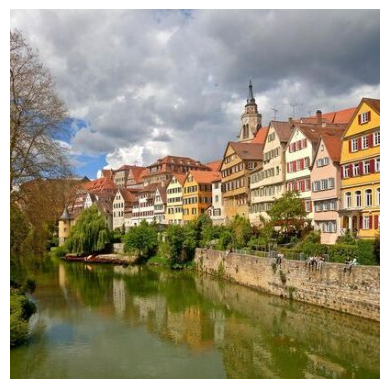

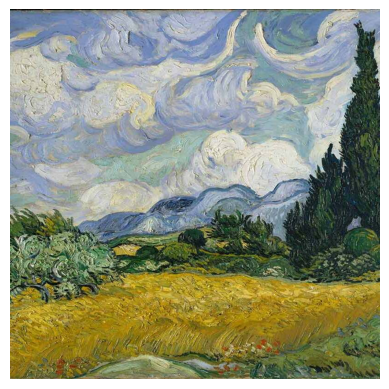

In [47]:
content_image = load_image(content_dir).to(device)
show_image(content_image, denormalization = True)
style_image = load_image(style_dir).to(device)
show_image(style_image, denormalization = True)

## Load Pre-trained VGG Model and Define Content and Style Layers:

In [48]:
# Define content layer
content_layer = 21  # 'conv4_2' corresponds to layer 21 in the VGG19 model

# Define style layers
style_layers = [0, 5, 10, 19, 28]  # 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1' correspond to layers 0, 5, 10, 19, 28 in the VGG19 model

In [57]:
# Create modified vgg19 model by replacting the maxPool with avgPool
modified_layers = []
# Iterate through the original model's layers
for name, layer in enumerate(vgg_model.children()):
    if name == 29:
          break
    # if isinstance(layer, nn.MaxPool2d):
    #     # Replace max pooling with average pooling
    #     modified_layers.append(nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding))
    else:
        # Keep other layers unchanged
        modified_layers.append(layer)

# Create a new model with the modified layers
modified_vgg19_model = nn.Sequential(*modified_layers).to(device)
for param in modified_vgg19_model.parameters():
    param.requires_grad = False


In [9]:
def extract_features(image, model, content_layer, style_layers):
  features = {}
  x = image


  for name, layer in enumerate(model):
    # print(name, layer, "here are namd and layer")
    prev_x = x
    x = layer(x)
    # assert x != prev_x
    if name in style_layers:
      # print(name)
      features[name] = x
    elif name == content_layer:
      # print(name)
      content_features = x

  return {'content': content_features, 'style': features}


In [58]:
content_features = extract_features(content_image, modified_vgg19_model, content_layer, style_layers)['content']
style_features = extract_features(style_image, modified_vgg19_model, content_layer, style_layers)['style']

## Compute Loss

In [11]:
def gram_matrix(input_tensor):
  # batch_size = 1, N = num of feature maps
  batch_size, N, h, w = input_tensor.size()
  # Reshape the input tensor into a 2D matrix where each row corresponds to a different feature map,
  # and each column corresponds to a flattened version of a feature map.
  features = input_tensor.view(batch_size * N, h * w)
  # take the inner product (dot product) of the vectorized feature maps
  G = torch.mm(features, features.t())
  # # Normalize the values of the Gram matrix by dividing by the total number of elements in each feature map.
  normalized_G = G.div(2 * N * h * w)
  return G

In [38]:
content_loss_fn = nn.MSELoss()
pre_process_layer = nn.Sigmoid()

In [13]:
class CustomNormalization(nn.Module):
  def __init__(self, mean, std):
    super(CustomNormalization, self).__init__()
    self.mean = mean
    self.std = std
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x_sigmoid = self.sigmoid(x)
    return (x_sigmoid - self.mean) / self.std

custom_normalization = CustomNormalization(normalization_mean.to(device), normalization_std.to(device)).to(device)

In [59]:
target_model = nn.Sequential(custom_normalization)
for name, layer in enumerate(vgg_model.children()):
  if name == 29:
          break
  # if isinstance(layer, nn.MaxPool2d):
  #   target_model.add_module(str(name), nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding))
  else:
    target_model.add_module(str(name), layer)

for param in target_model.parameters():
    param.requires_grad = False


In [15]:
#wandb.init(
#    project="testing_starry_1e1_1e-7",
#    entity = "jding25")

In [61]:
# target_image = torch.nn.Parameter(torch.randn_like(content_image).to(device), requires_grad=True)
assert target_image.shape == content_image.shape
optimizer = optim.Adam([target_image], lr = 0.03)
steps = 47100

content_weight, style_weight = 5e2, 1e-5
for i in range(15000):

  # retrieve the content features and style features
  target_features = extract_features(target_image, target_model, content_layer, style_layers)

  target_content_feature, target_style_feature = target_features['content'], target_features['style']

  # calculate content_loss
  content_loss = torch.nn.functional.mse_loss(target_content_feature, content_features)

  # calculate style_loss
  style_loss = 0
  for layer in target_style_feature.keys():
    target_layer = target_style_feature[layer]
    style_layer = style_features[layer]
    curr_style_loss = torch.nn.functional.mse_loss(gram_matrix(target_layer), gram_matrix(style_layer))
    style_loss += 0.2 * curr_style_loss


  # calculate total_loss:
  total_loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if (i + 1) == steps:
    show_image(pre_process_layer(target_image), save = True, append_to_list = True)
  if (i) % 100 == 0:
    print('Step ', i)
    print('Style loss ', style_loss * style_weight)
    print('Content loss ', content_loss * content_weight)
    print('Total loss: ', total_loss.item())
    #wandb.log({"style_loss": style_loss * style_weight, "content_loss": content_loss * content_weight, "total_loss":total_loss.item(), "epoch":i})
    show_image(pre_process_layer(target_image), append_to_list = True)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#wandb.finish()

In [1]:
from PIL import Image
# Assuming all_frames is a list of numpy.ndarray objects
pil_frames = [Image.fromarray((frame * 255).astype(np.uint8)) for frame in image_list]

# Save as GIF
pil_frames[0].save(output_name.split('.')[0]+'.gif', save_all=True, append_images=pil_frames[1:], duration=1000 // 60, loop=0)

NameError: ignored